In [7]:
ls*

L1_kickstart_for_lms.ipynb               __pycache__/
lec1_AND_task1.ipynb                     pylift_utils.py
minethatdata_womens_test_no_answers.csv  stat.csv
minethatdata_womens_train.csv


In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pylift_utils

In [4]:
train = pd.read_csv('minethatdata_womens_train.csv')
test = pd.read_csv('minethatdata_womens_test_no_answers.csv')

In [5]:
train.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0


In [6]:
# Описание клиента до рассылки (контекст)

# recency: количество месяцев с последней покупки
# history_Segment: категория (определяется по количеству $, потраченных за последний год)
# history: количество $, потраченных за последний год
# mens: индикатор, 1 - клиент купил товары для мужчин за последний год
# womens: индикатор, 1 - клиент купил товары для женщин за последний год
# zip_Code: региональная категория индексов: Urban, Suburban, или Rural.
# newbie: индикатор, 1 - новый клиент (пришел в магазин в первый раз за последние 12 месяцев)
# channel:  описывает способы приобретения клиентом товаров за последний год

In [7]:
# В этой переменной указано то, к какой группе был отнесен клиент

# segment: "Mens E-Mail" / "Womens E-Mail" / "No E-Mail"

# No E-Mail - control


# Переменные, описывающие клиента в течение 2 недель после получения e-mail

# visit: индикатор, 1 - клиент посетил сайт в последующие 2 недели после рассылки
# conversion: индикатор, 1 - клиент купил товары на сайте в последующие 2 недели после рассылки
# spend: количество $ потраченных на покупки в последующие 2 недели

In [8]:
act_list = ['visit', 'conversion', 'spend']

In [9]:
ll = []

for var in act_list:
    l = train.groupby('segment')[var].mean().values.tolist()
    ate = l[1]-l[0]
    rel = l[1]/l[0]
    l.append(ate)
    l.append(rel)
    ll.append(l)

In [60]:
df = pd.DataFrame(ll, columns=['mean_control', 'mean_treated', 'ate', 'relative_change'], index=act_list)
df.index = df.index.set_names(['variable'])
df = df.reset_index()
df

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


In [61]:
df.to_csv('stat.csv', index=False)

In [62]:
train

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21341,39579,10,3) $200 - $350,282.34,1,0,Urban,0,Phone,No E-Mail,0,0,0.0
21342,57462,1,1) $0 - $100,76.88,1,0,Rural,1,Web,Womens E-Mail,1,0,0.0
21343,55147,3,1) $0 - $100,29.99,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
21344,55020,11,1) $0 - $100,68.53,0,1,Surburban,1,Web,Womens E-Mail,1,0,0.0


In [154]:
train_copy = train.copy()
control = train[train.segment=='No E-Mail']
treat = train[train.segment=='Womens E-Mail']

var = 'spend'

bootstap_l = []

for rs in tqdm(range(1000)):
    
    control_boot = control.sample(frac=1, replace=True, random_state=rs)
    treat_boot = treat.sample(frac=1, replace=True, random_state=rs)
    
    conc = pd.concat([control_boot, treat_boot])
    
    l = conc.groupby('segment')[var].mean().values.tolist()
    
#     ate = l[1]-l[0]
#     bootstap_l.append(ate)
    
    rel = l[1]/l[0]
    bootstap_l.append(rel)
    
alpha = 0.9
ordered = np.sort(bootstap_l)
lower = np.percentile(ordered, (1-alpha)/2 * 100)
upper = np.percentile(ordered, (alpha+((1-alpha)/2))  * 100)

np.mean(bootstap_l), lower, upper

100%|██████████| 1000/1000 [00:09<00:00, 110.14it/s]


(2.0004698247485733, 1.3260187904992562, 2.909424684560365)

Видим, что разброс относительного прироста метрик conversion и spend велик. Поэтому шансы получить хорошую uplift-модель для этих метрик мал.

In [148]:
# import numpy as np
# import scipy.stats

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m-h, m+h

In [147]:
# mean_confidence_interval(bootstap_l, confidence=0.9)

In [149]:
# import numpy as np, scipy.stats as st
# st.t.interval(alpha=0.9, df=len(bootstap_l)-1, loc=np.mean(bootstap_l), scale=st.sem(bootstap_l))

# model

In [10]:
data = pd.concat([train, test])

In [11]:
data = data.reset_index(drop=True)

In [12]:
train_index = data[:len(train)].index
test_index = data[len(train):].index

In [13]:
data_womens = data.query('segment in ("No E-Mail", "Womens E-Mail")')

In [14]:
data_womens['treatment'] = (data_womens['segment'] == "Womens E-Mail").astype('int32')

In [15]:
from typing import List

In [16]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [17]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [18]:
data_womens = transform_(data_womens)

In [19]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

In [20]:
column_set_n2 = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web',
    'history_segment__label_1', 'history_segment__label_2',
    'history_segment__label_3', 'history_segment__label_4',
    'history_segment__label_5', 'history_segment__label_6',
    'history_segment__label_7'
]

In [21]:
import pylift

In [22]:
upmodel_n0 = pylift.TransformedOutcome(
    data_womens.loc[train_index, column_set_n1 + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=2
)

In [23]:
upmodel_n0.transformed_y_train

11513         -0
11014    1.99328
7386          -0
19397          0
18209          0
          ...   
4537           0
5226           0
16655   -2.00677
2780          -0
13158         -0
Name: TransformedOutcome, Length: 21344, dtype: object

In [24]:
upmodel_n0.fit()

/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/pylift/eval.py:474: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1_qini'] = scores['Q_qini']/scores['Q_max']
/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/pylift/eval.py:475: RuntimeWarning: invalid value encountered in double_scalars
  scores['q2_qini'] = scores['Q_qini']/scores['Q_practical_max']
/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/pylift/eval.py:479: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1_cgains'] = scores['Q_cgains']/scores['Q_max']
/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/pylift/eval.py:480: RuntimeWarning: invalid value encountered in double_scalars
  scores['q2_cgains'] = scores['Q_cgains']/scores['Q_practical_max']
/home/atuthvatullin/environments/albert/lib/python3.6/site-packages/pylift/eval.py:484: RuntimeWarning: invalid value encountered in double_scalars
  scores['q1

In [25]:
eval_data = data_womens.loc[test_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment', 'visit']]

In [26]:
# !pip install -U seaborn

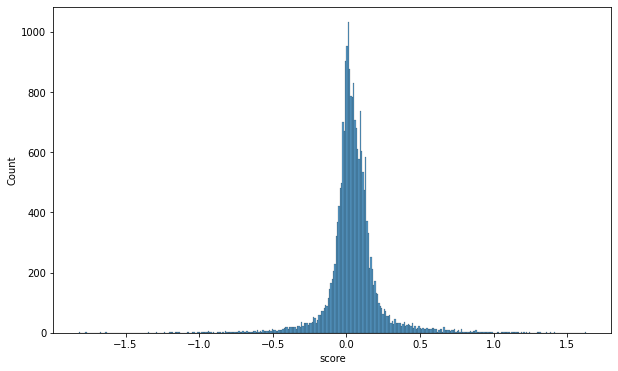

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

In [38]:
pd.concat([eval_data.reset_index(drop=True), test], axis=1)[['index', 'score']].to_csv('test_pred.csv', index=False)